In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm import tqdm
import datetime
from scipy import interpolate
import math
import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)
    
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)
from AOE.gp_bandit import gp_bandit_finance, Wasserstein_GP_mean, ExactGPModel

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GpGenerator:
    def __init__(self, train_x, train_y, lengthscale = None):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise = 1e-4
        likelihood.noise_covar.raw_noise.requires_grad_(False)
        self.model = ExactGPModel(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float), likelihood = likelihood, lengthscale=lengthscale)
        
    def sample_posterior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        self.model.add_point(x, y)
        return y
        
    def sample_prior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        return y
    
def normalize_regret(x):
    return (torch.tanh(x) + 1)/2

# Synthetic Experiment

In [3]:
strategies  = {'arm1' : {'contextual_params': {'feature_name'  : 'feature'}},
               'arm2' : {'contextual_params': {'feature_name'  : 'feature'}}}
seed = 2
torch.manual_seed(seed)

In [12]:
# Parameters bandit
size_buffer   = 100
size_window   = 16
training_iter = 30
bandit_params = 0.1
threshold = 0.5
likelihood    = gpytorch.likelihoods.GaussianLikelihood()
bandit_algo   = 'TS'
bandit = gp_bandit_finance(strategies, bandit_algo=bandit_algo, bandit_params=bandit_params, training_iter=training_iter, size_buffer=size_buffer, size_window=size_window, threshold=threshold)

In [13]:
# Parameters environment
T = 400
N = 2
T_N = T//N
reward1 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
reward2 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
def generate_x():
    x_new = 2*torch.rand(1) - 1
    return x_new, pd.Series(data={'feature': x_new}, index=['feature'])

100%|█████████████████████████████████████████| 200/200 [01:12<00:00,  2.74it/s]


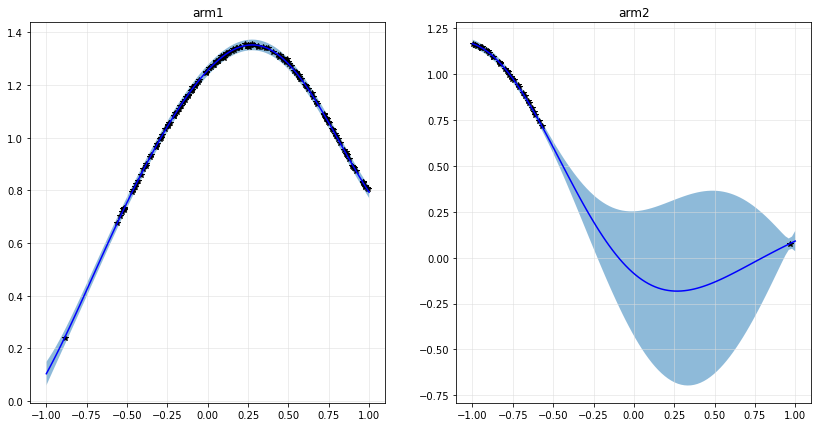

  4%|█▋                                         | 8/200 [00:03<01:16,  2.52it/s]

W2 distance 0.6459980665755638


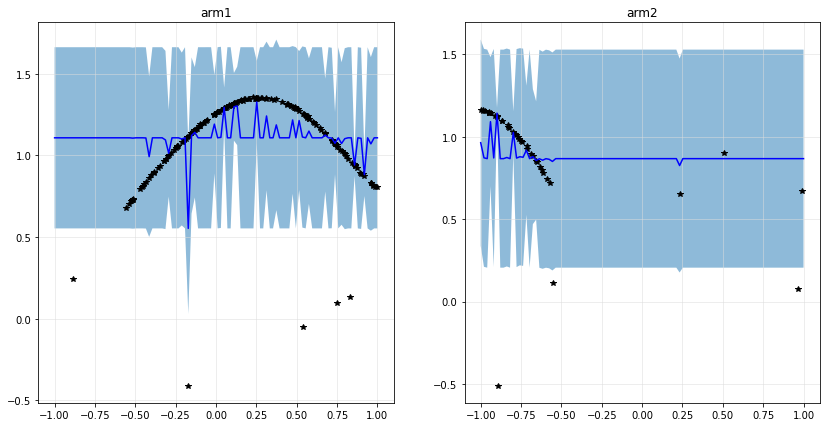

  6%|██▎                                       | 11/200 [00:04<00:55,  3.42it/s]

Regime change detected for strategy arm2, corresponding arm reinitialized


100%|█████████████████████████████████████████| 200/200 [01:18<00:00,  2.56it/s]


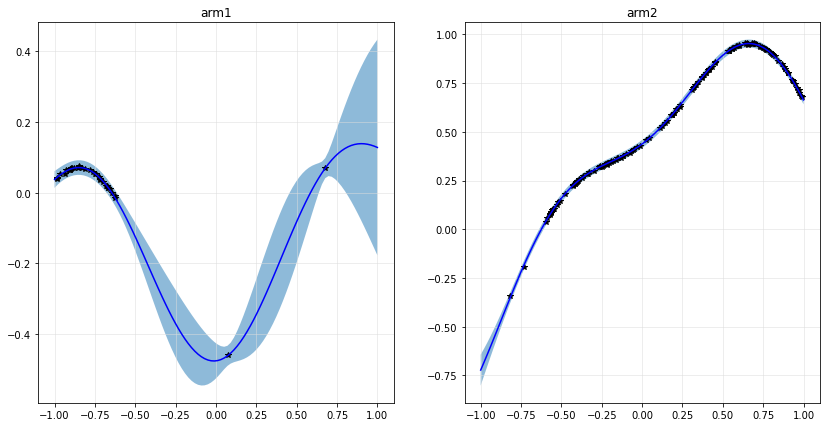

In [28]:
# Simulation bandit
regret_sim = torch.zeros(T)
for i in range(N):
    
    # New underlying reward distribution for both arms
    reward1 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    reward2 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    for t in tqdm(range(T_N)):
        x_new, df_new = generate_x()
        best_strategy_bandit  = bandit.select_best_strategy(df_new)
        r1, r2 = reward1.sample_posterior(x_new), reward2.sample_posterior(x_new)
        
        if best_strategy_bandit == "arm1":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r1)
            bandit.update_data(df_new, best_strategy_bandit, r1, retrain_hyperparameters = True)
            
        elif best_strategy_bandit == "arm2":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r2)
            bandit.update_data(df_new, best_strategy_bandit, r2, retrain_hyperparameters = True)
        
        d, change_point = bandit.change_point(best_strategy_bandit) 
        if change_point:
            print(f"W2 distance {d}")
            bandit.plot_strategies()
            bandit.reinitialize_arm()
        regret_sim[i*T_N + t] = regret_t
    bandit.plot_strategies()

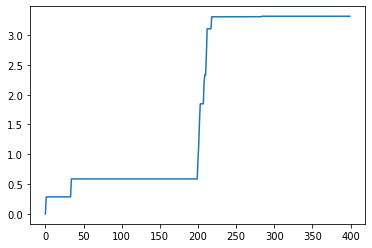

In [29]:
cum_regret = torch.cumsum(regret_sim, dim=0)
plt.plot(range(T), cum_regret)

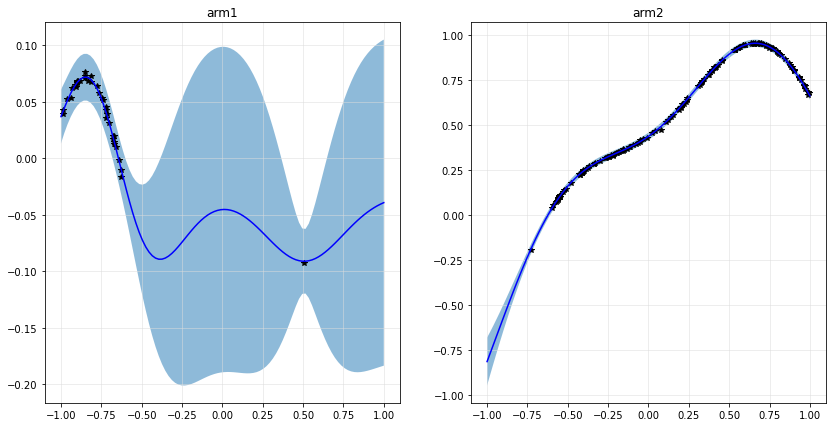

In [22]:
bandit.plot_strategies()

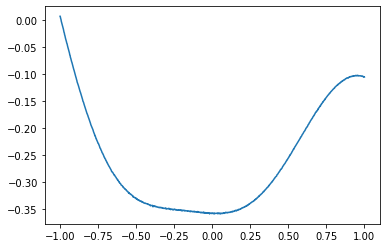

In [65]:
reward = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
test_x = torch.linspace(-1, 1, 1000, dtype=torch.float).reshape(-1,1)
y_test = reward.sample_prior(test_x)
plt.plot(test_x, y_test)

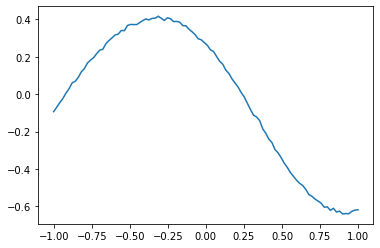

In [79]:
reward = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
test_x = torch.linspace(-1, 1, 100, dtype=torch.float).reshape(-1,1)
y_test = torch.zeros(100, dtype=torch.float)
for i, el in enumerate(test_x):
    with torch.no_grad():
        y_test[i] = reward.sample_posterior(el)
plt.plot(test_x, y_test)

In [80]:
y_test = torch.zeros(100, dtype=torch.float)
x_test = torch.tensor([0.])
for i in range(100):
    with torch.no_grad():
        y_test[i] = reward.sample_posterior(x_test)

In [84]:
torch.max(reward.sample_posterior(x_test), reward.sample_posterior(x_test))

tensor([0.2686])

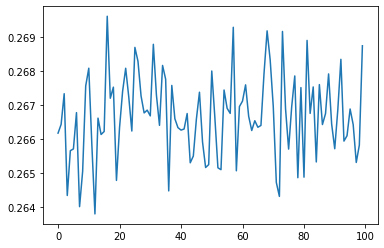

In [81]:
plt.plot(range(100), y_test)

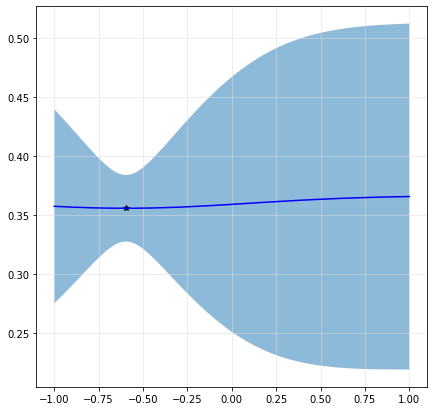

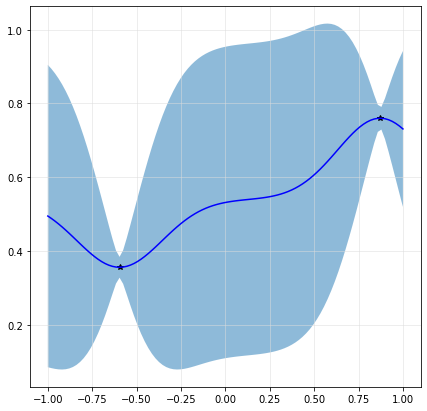

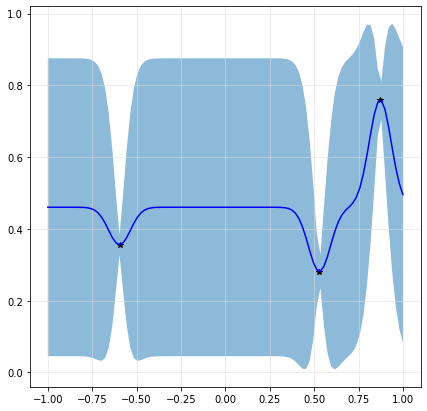

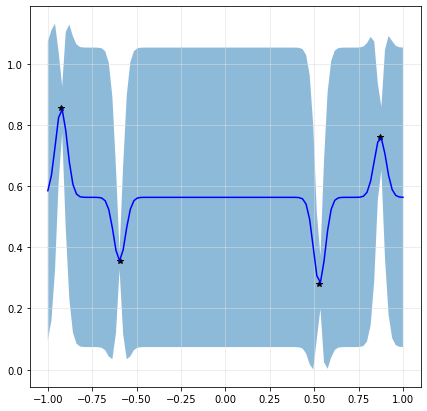

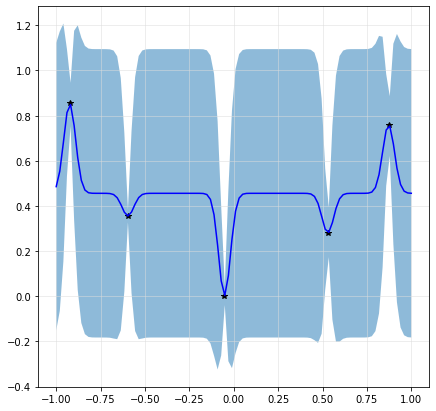

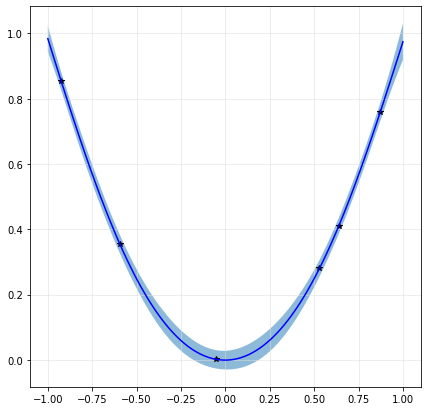

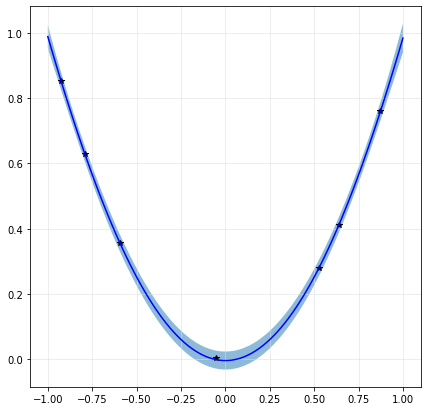

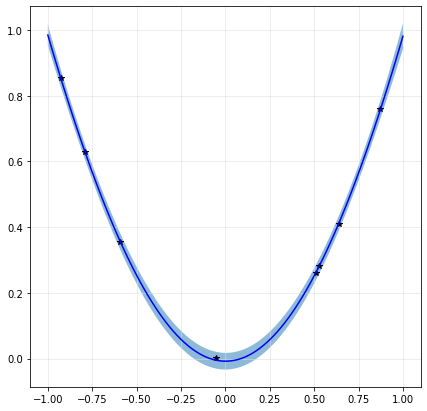

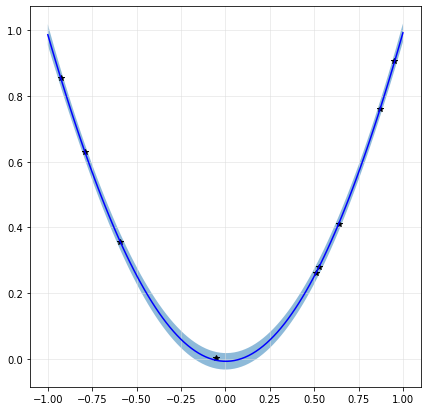

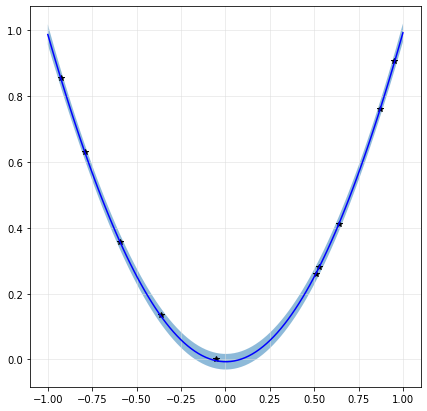

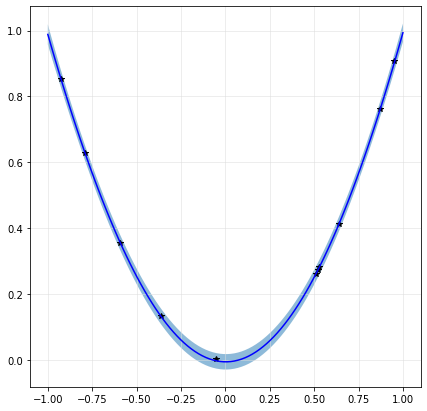

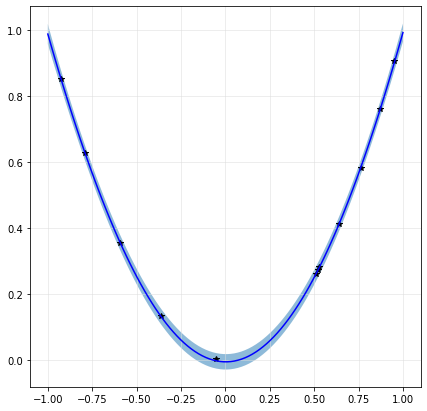

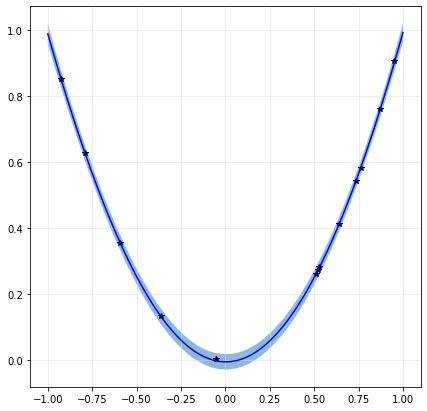

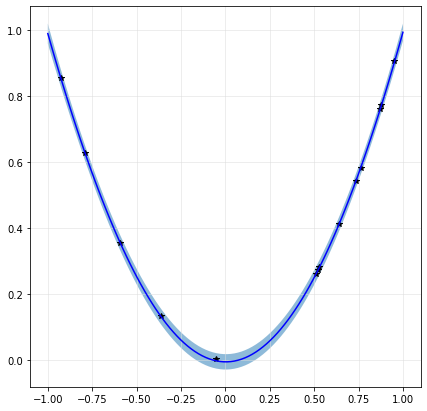

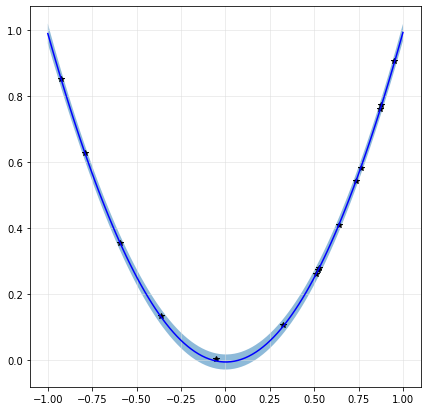

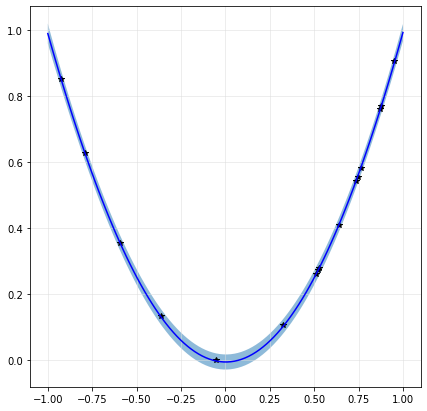

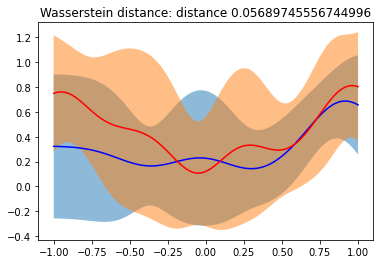

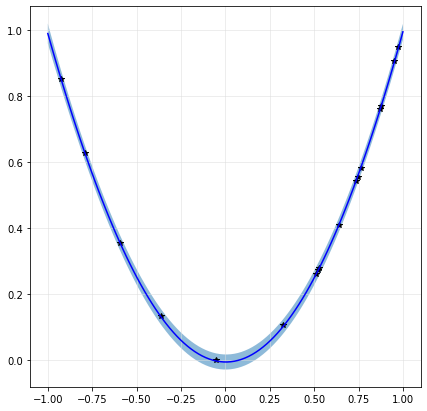

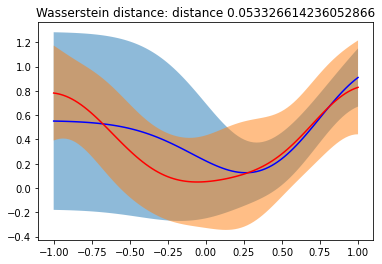

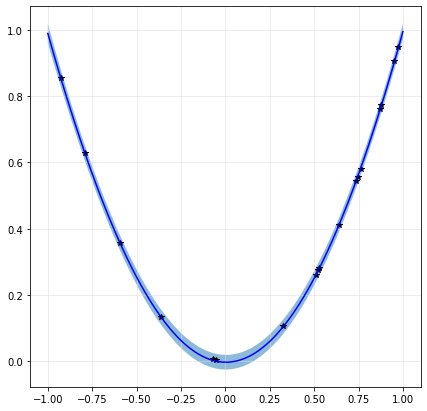

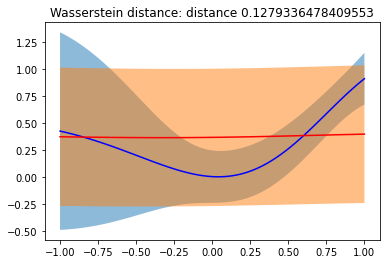

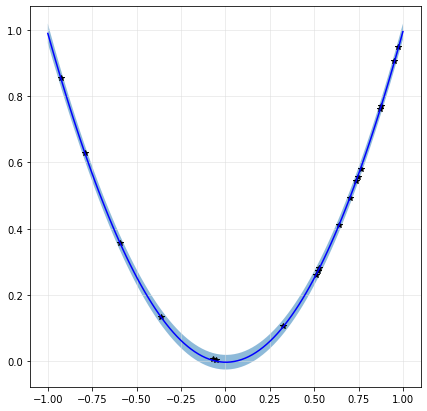

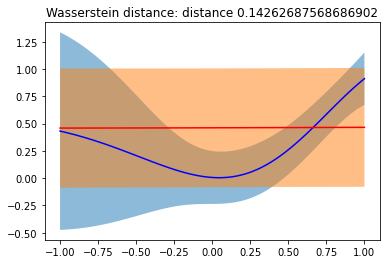

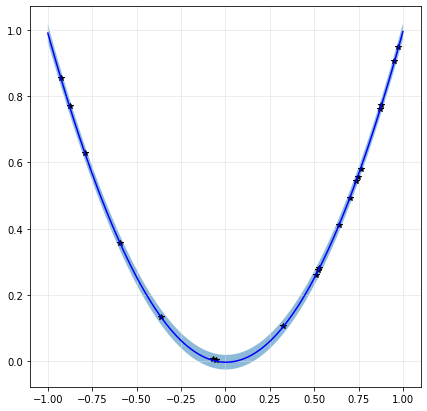

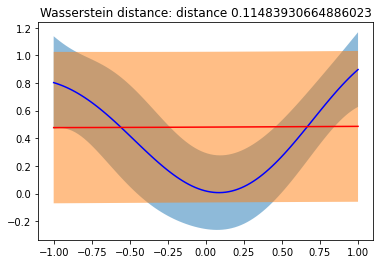

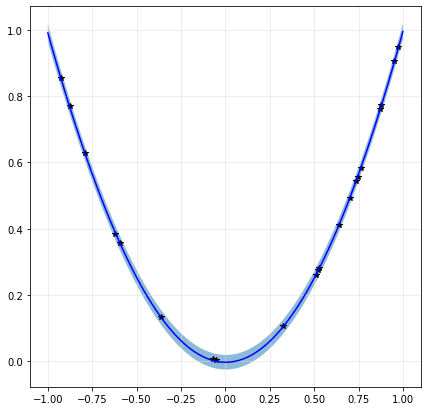

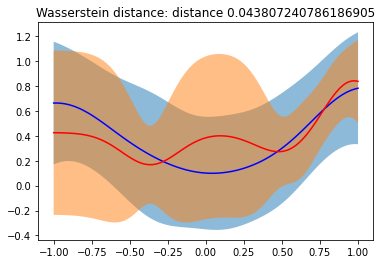

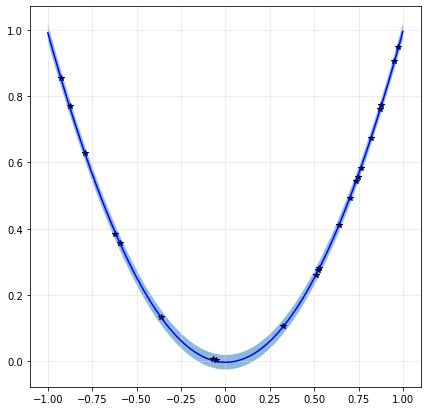

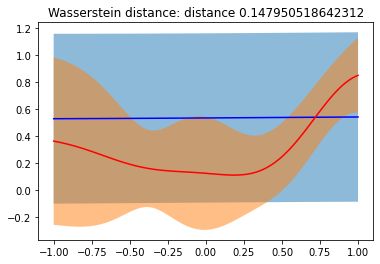

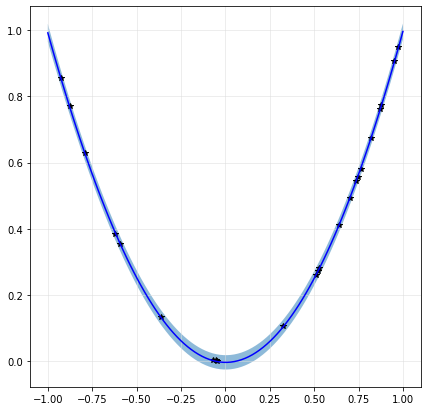

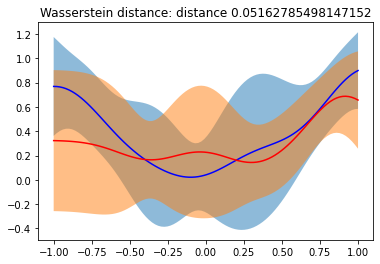

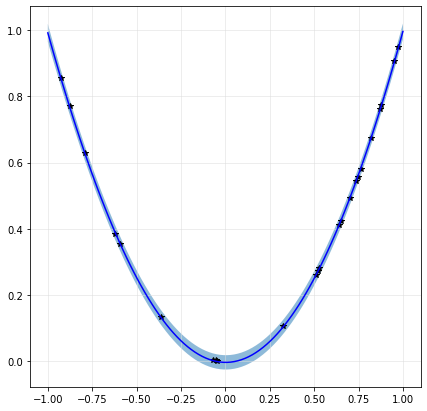

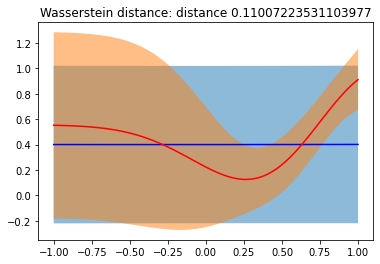

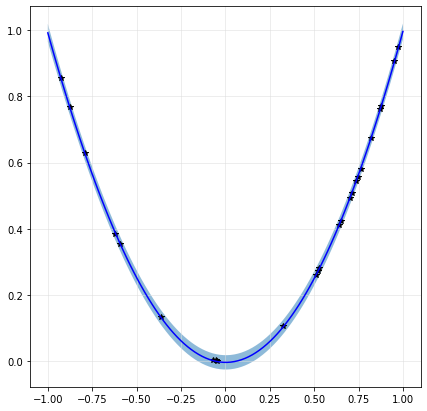

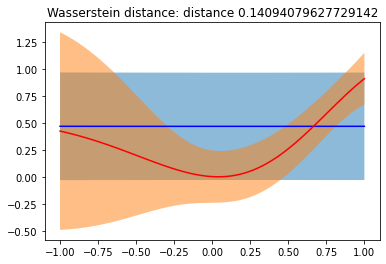

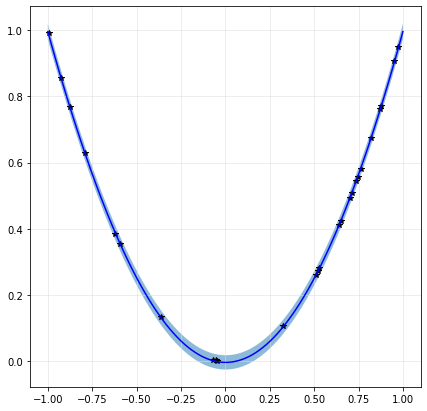

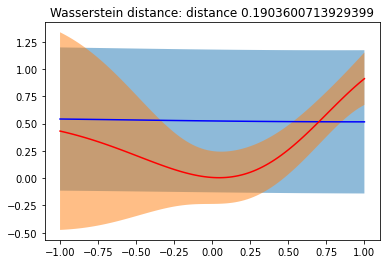

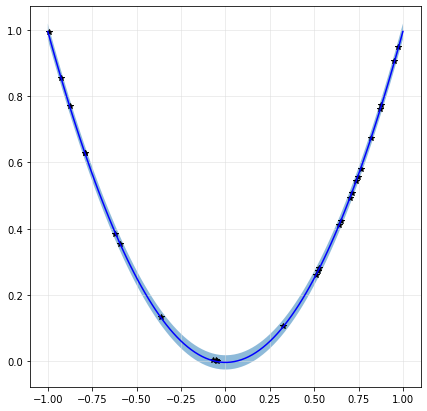

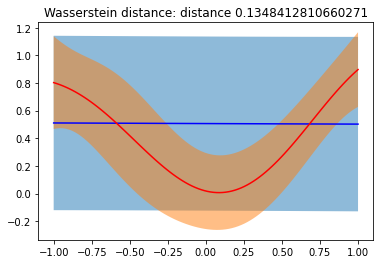

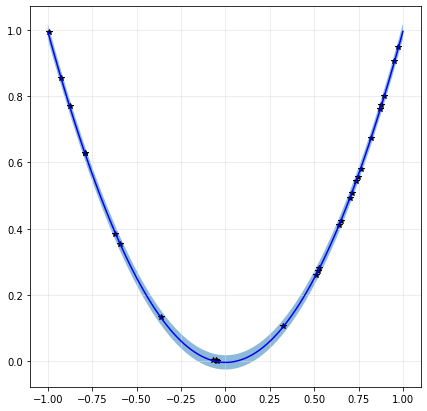

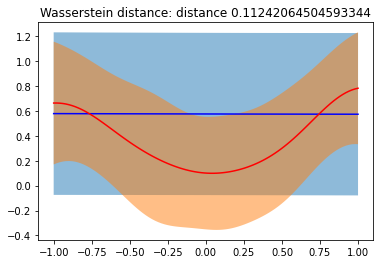

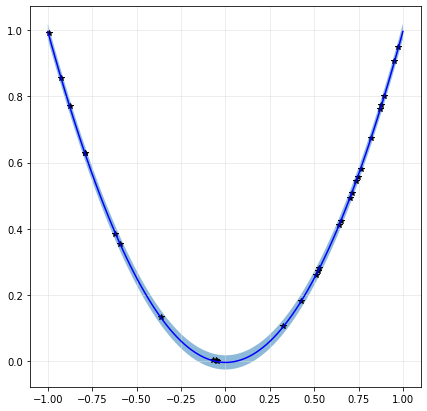

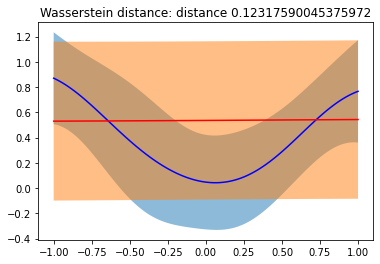

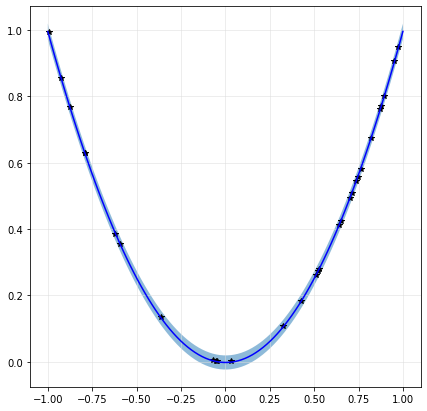

---------------Change of regime!!!! ------------------


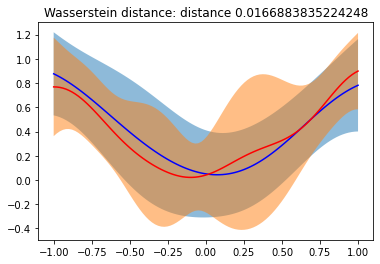

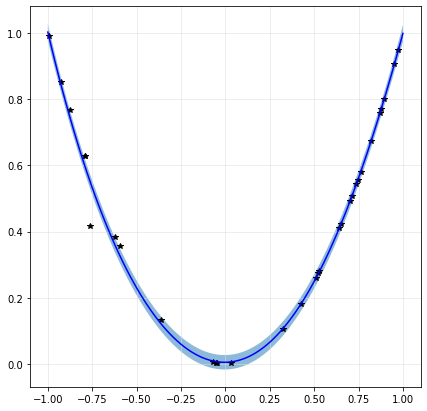

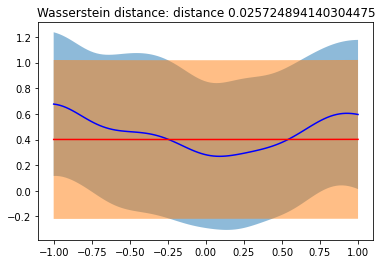

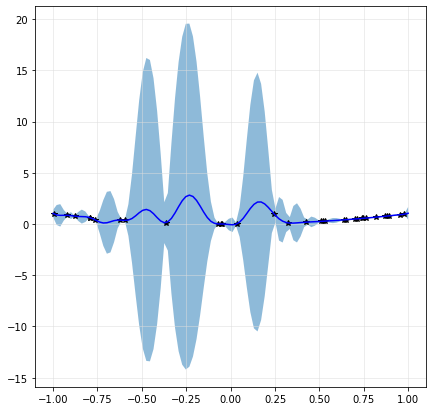

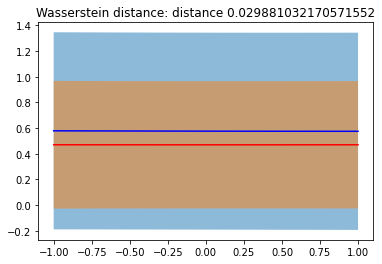

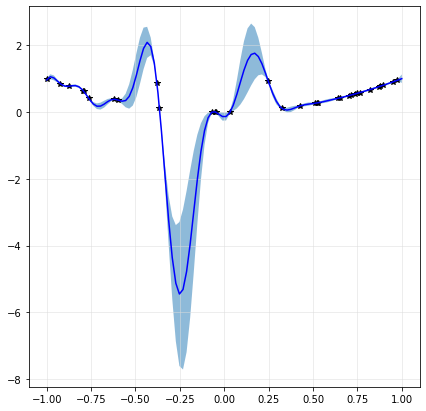

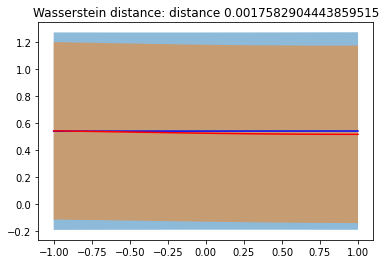

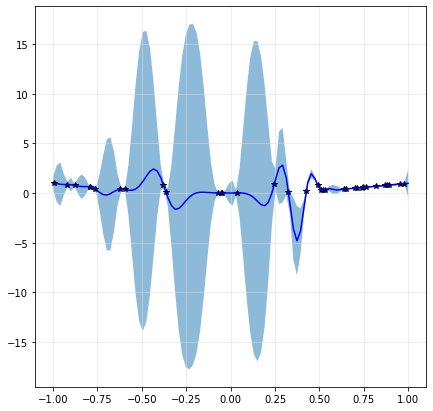

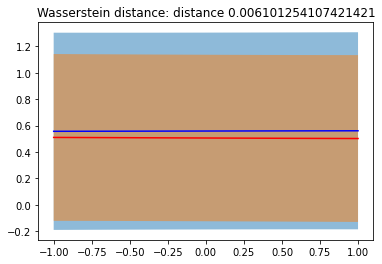

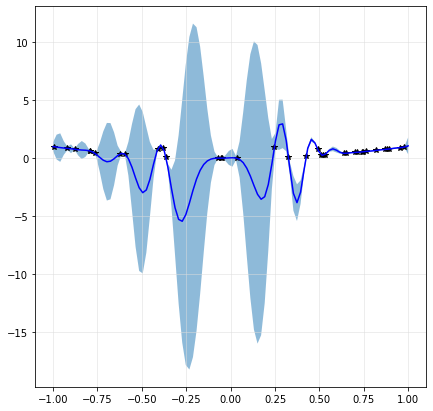

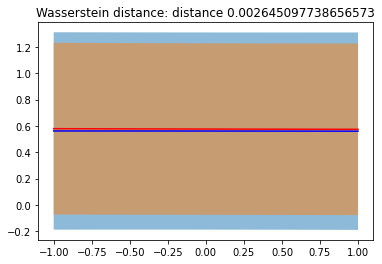

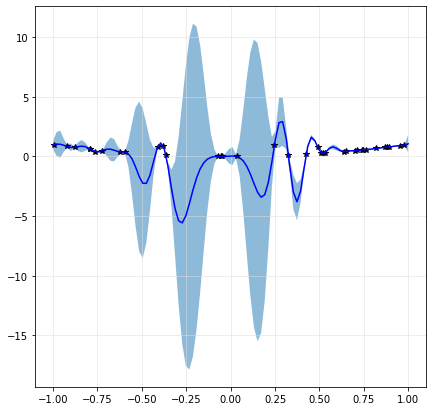

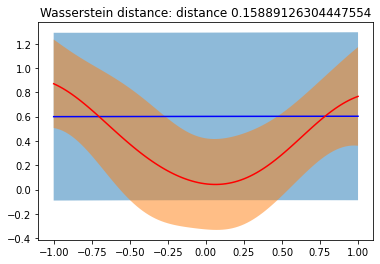

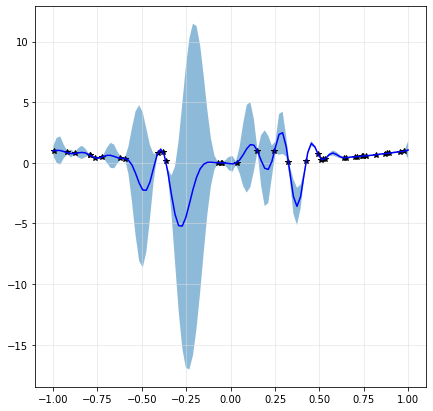

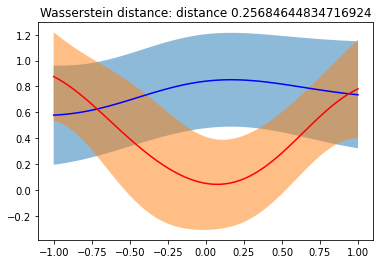

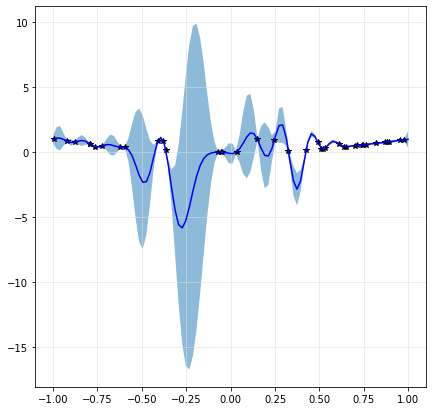

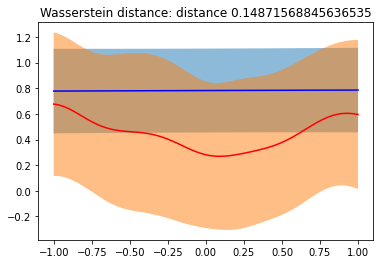

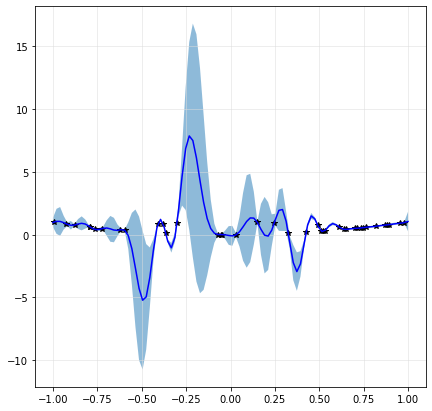

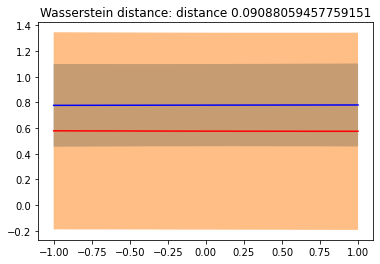

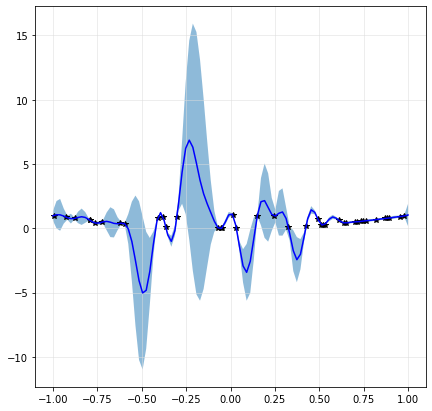

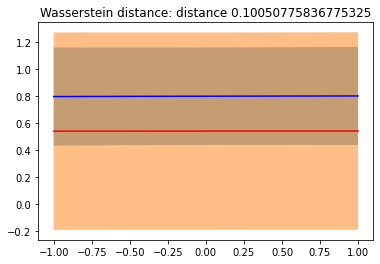

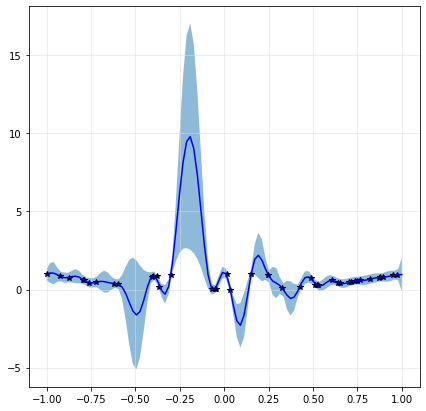

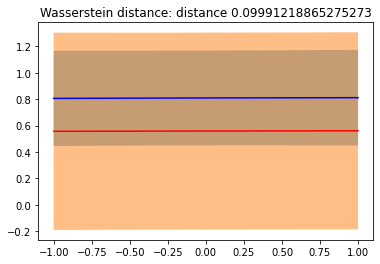

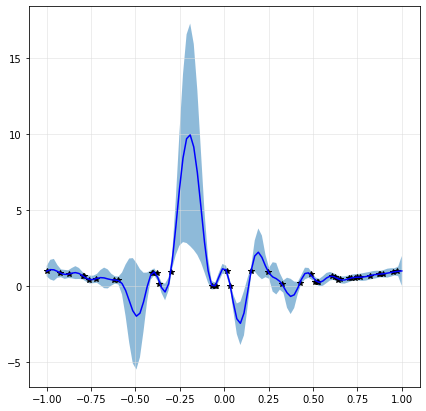

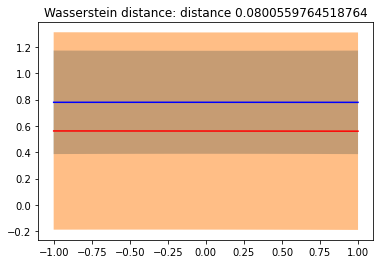

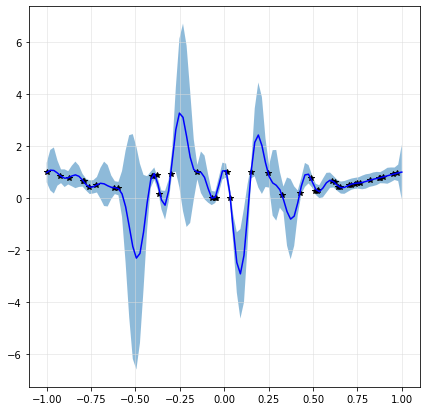

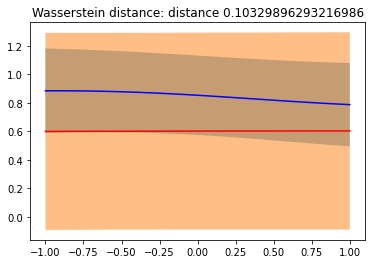

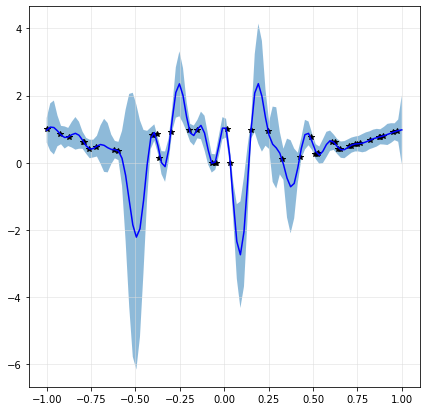

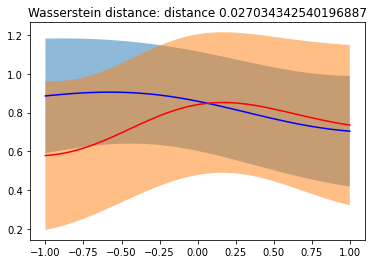

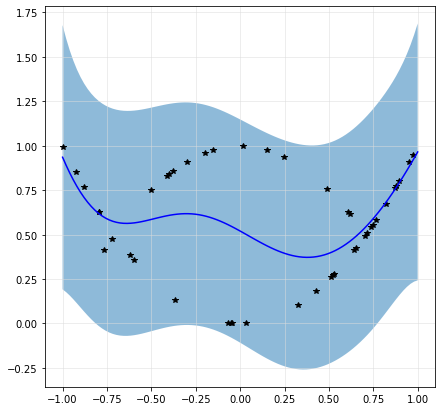

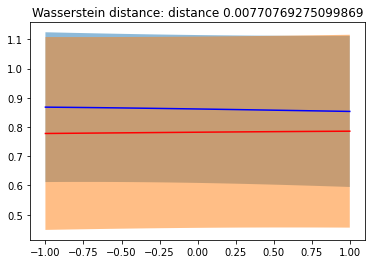

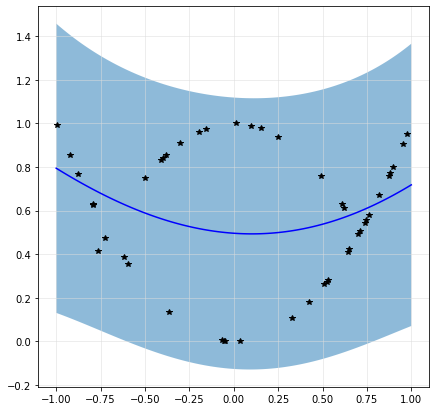

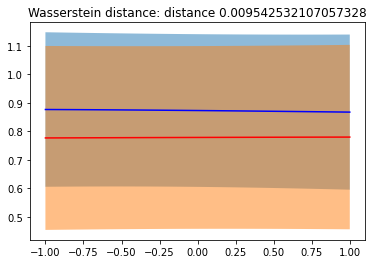

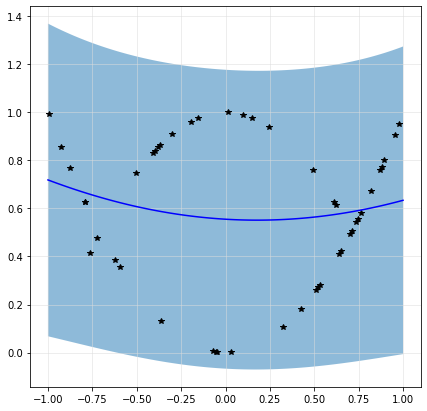

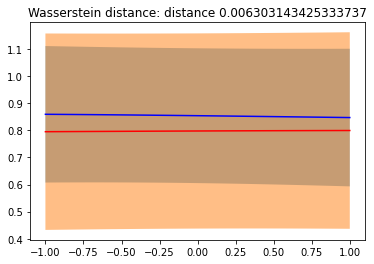

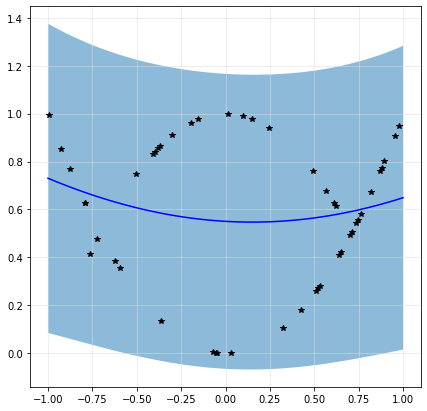

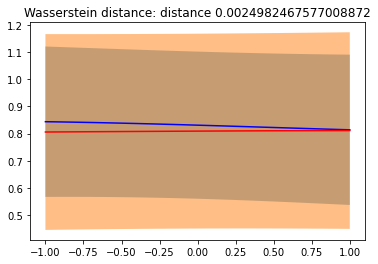

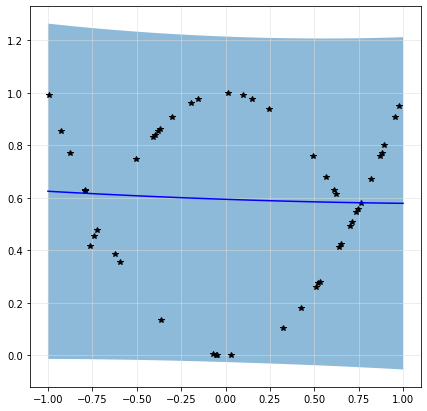

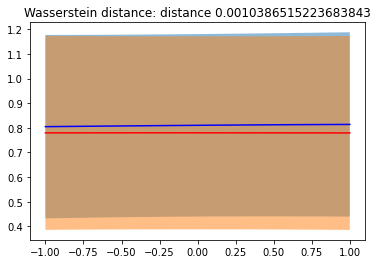

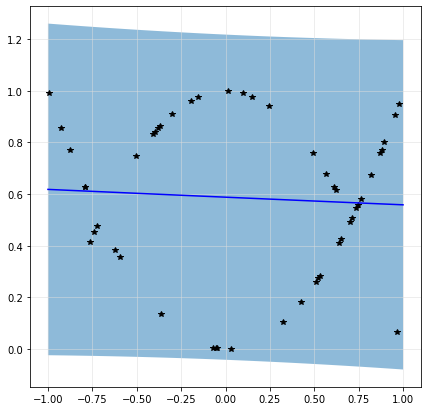

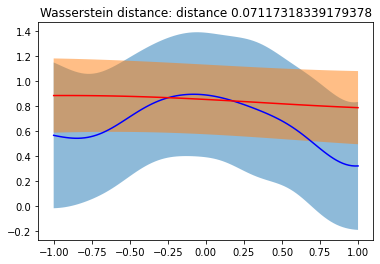

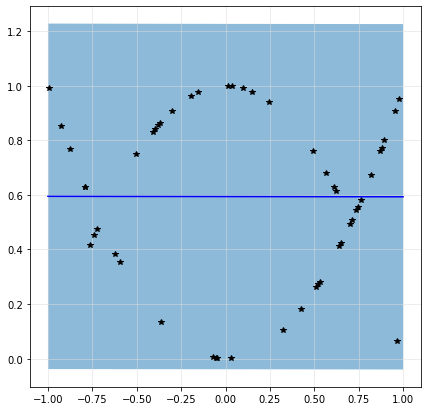

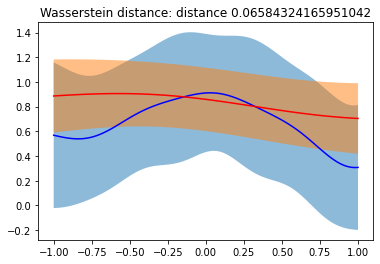

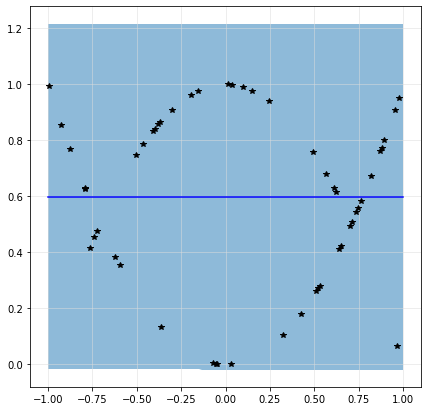

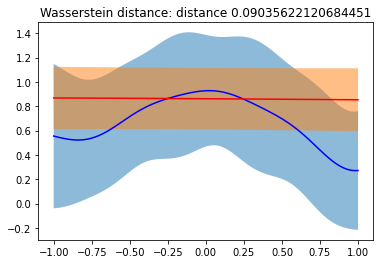

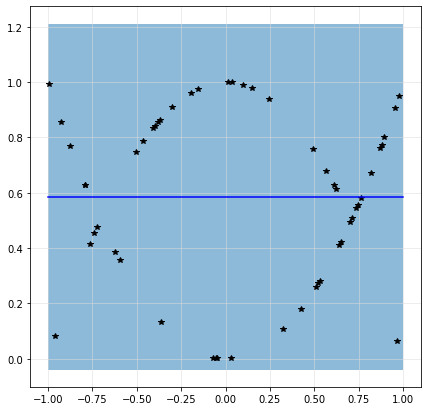

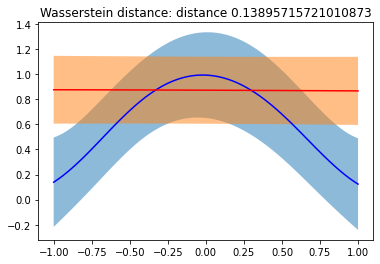

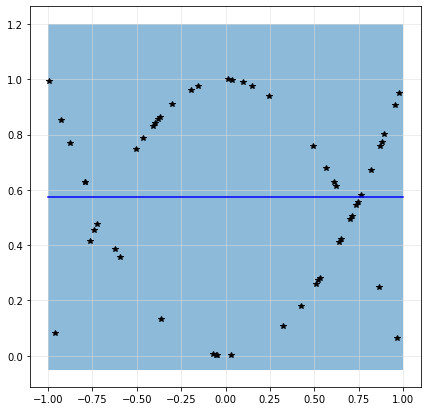

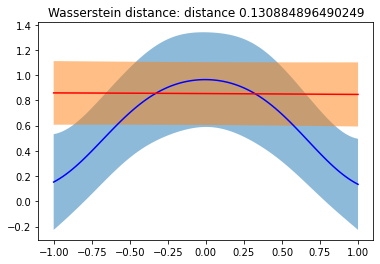

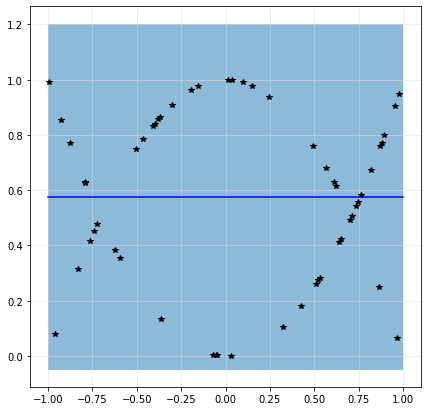

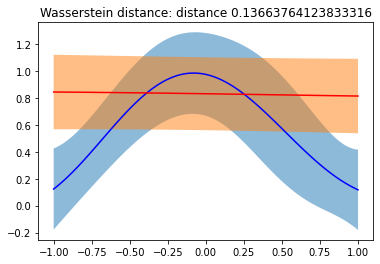

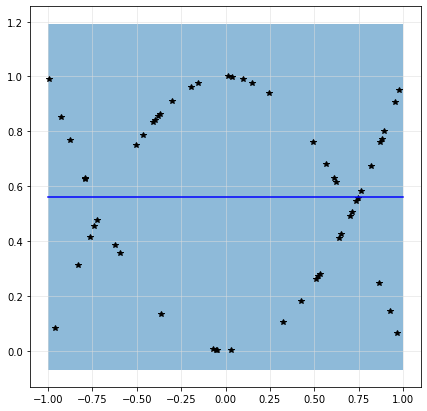

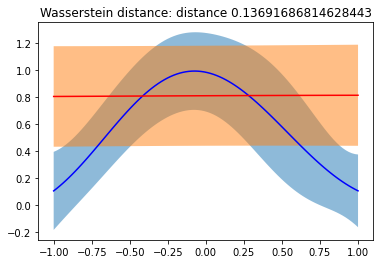

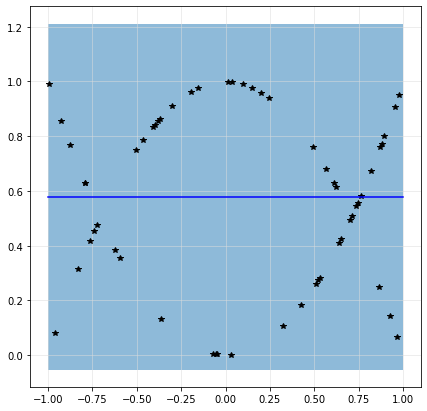

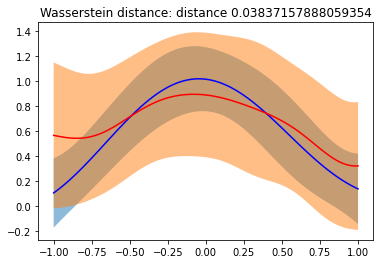

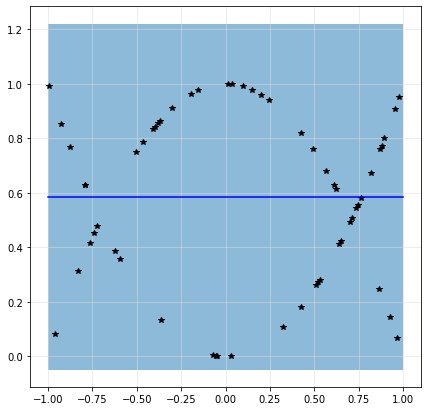

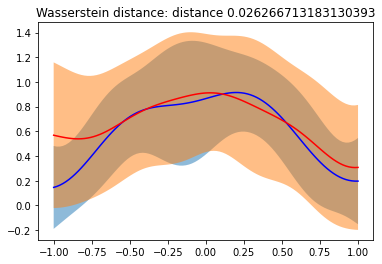

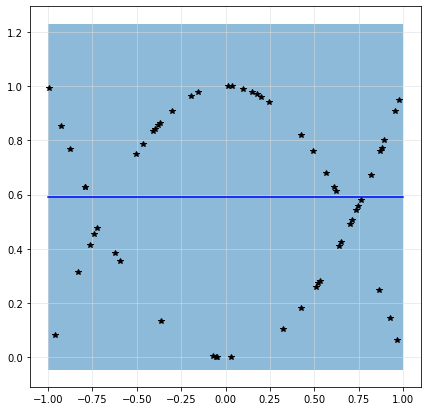

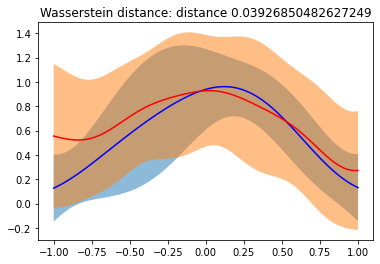

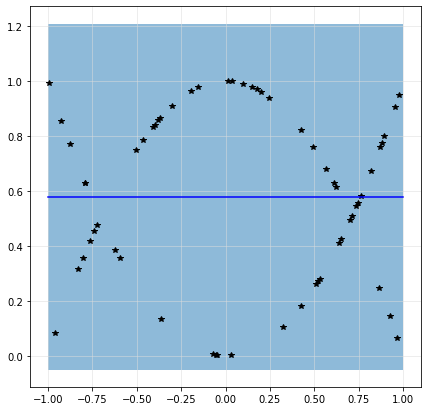

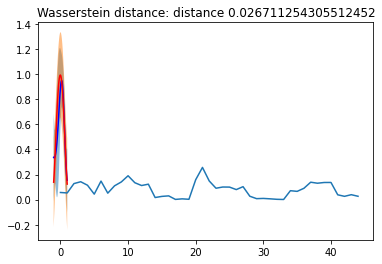

In [17]:
%matplotlib inline

## Plot both gp and value ucb at each time step with data point
## Try non stationarity
## Create synthetic random datapoints
size_window = 14
bandit = gp_bandit_finance(strategies, size_window=size_window)
reward_1 = lambda x: x**2
reward_2 = lambda x: -x**2 + 1
d = {'vol_50_50000': np.random.normal()}

distances = []

for i in range(30):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    reward = reward_1(d['vol_50_50000'])
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    bandit.plot_strategies(["imbalance"])
    if i > size_window:
        
        posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_confidence("imbalance")
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')
        
        posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window_covar("imbalance")
        
        distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        distances.append(distance)
        
        ax.set_title(f"Wasserstein distance: distance {distance}")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)

print("---------------Change of regime!!!! ------------------")
for i in range(30):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    reward = reward_2(d['vol_50_50000'])
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    bandit.plot_strategies(["imbalance"])
    
    posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_confidence("imbalance")
    test_x = torch.linspace(-1, 1, 100).double()
    f, ax = plt.subplots(1, 1)

    ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
    ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')

    posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window_covar("imbalance")

    distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
    distances.append(distance)

    ax.set_title(f"Wasserstein distance: distance {distance}")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
    ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
    #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)
        
plt.plot(distances)